In [0]:
root_folder = '/content/drive/My Drive/Colab Notebooks/SMAI/2019201089-Assignment 2/'
train_data_folder = root_folder + 'Datasets/Question-1'

In [0]:
import numpy as np
from sklearn.svm import LinearSVC, SVC
from skimage.feature import hog
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow
import matplotlib
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

In [0]:
import os
os.chdir(train_data_folder)

In [5]:
!ls

 batches.meta		  data_batch_2	 data_batch_5	    readme.html
 cifar-10-python.tar.gz   data_batch_3	'readme (1).gdoc'   test_batch
 data_batch_1		  data_batch_4	 readme.gdoc


##SIGNIFICATION OF C IN SVM
C basically takes care of slack variable and sees wheather the $\sum\epsilon$ is taken in to account while doing the legrange minimizaiton of cost

In [0]:
class svm_cfar10():
    def __init__(self, files=['data_batch_'+str(i) for i in range(1,6)], feature=None, C=.8, kernel='linear'):
        self.train_x = self.train_y = self.N  =None
        self.val_x = self.val_y = None
        self.files = files
        self.feature = feature
        self.C = C
        self.kernel = kernel
        self.model = None

    def unpickle(self, file):
        import pickle
        with open(file, 'rb') as fo:
            _dict = pickle.load(fo, encoding='bytes')
        return _dict

    def fetch_data(self):
        self.train_x, self.train_y = np.array([], np.uint8), np.array([], np.uint8)
        for file in self.files:
            _dict = self.unpickle(file)
            self.train_y = np.append(self.train_y, _dict[b'labels'])
            if len(self.train_x) == 0:
                self.train_x = _dict[b'data']
            else:
                # print(self.train_x.shape,_dict[b'data'].shape)
                self.train_x = np.append(self.train_x, _dict[b'data'], axis=0)
        # self.train_x, self.train_y = self.train_x[:500], self.train_y[:500]
        return self.train_x, self.train_y

    def train(self, files=['data_batch_'+str(i) for i in range(1,6)]):
        self.fetch_data()
        if self.feature is None:
            self.model = LinearSVC(C=self.C)
            
            print(self.model)
            
            train_x = self.train_x / np.linalg.norm(self.train_x, ord=2, axis=1, keepdims=True)
            self.model.fit(train_x , self.train_y)
        elif self.feature == 'hog':
            train_x = None
            args = {'pixels_per_cell':(8,8),
                    'cells_per_block':(2,2),
                    'multichannel':True}
            train_x_2d = self.train_x.reshape(-1,3,32,32).transpose(0,2,3,1)

            for image in train_x_2d:
                if train_x is None:
                    train_x = hog(image, pixels_per_cell=(8,8), cells_per_block=(2,2), multichannel=True).reshape(1,-1)
                else:
                    train_x = np.append(train_x, hog(image, pixels_per_cell=(8,8), cells_per_block=(2,2), multichannel=True).reshape(1,-1), axis=0)

            train_x = train_x / np.linalg.norm(train_x, ord=2, axis=1, keepdims=True)


            if self.kernel != 'rbf':
                
                self.model = LinearSVC(C=self.C)
                print(self.model)

                self.model.fit(train_x, self.train_y)
            else:
                self.model = SVC(C=self.C)
                print(self.model)

                self.model.fit(train_x, self.train_y)

    def _train(self, train_x, train_y, val_x):
        if self.feature is None:
            self.model = LinearSVC(C=self.C)
            
            print(self.model)
            
            train_x = train_x / np.linalg.norm(train_x, ord=2, axis=1, keepdims=True)
            self.model.fit(train_x , train_y)
        else:
            pass
        pred_val_y = self._predict(val_x)
        return pred_val_y

    def get_support_vectors(self):
        if self.kernel == 'rbf':
            return self.model.support_vectors_
        else:
            print("error")

    def _predict(self, validation_set):
        validation_set = validation_set / np.linalg.norm(validation_set, ord=2, axis=1, keepdims=True)
        return self.model.predict(validation_set)

    def predict(self, files=['test_batch']):
        self.test_x, self.test_y = np.array([], np.uint8), np.array([], np.uint8)
        for file in files:
            _dict = self.unpickle(file)
            self.test_y = np.append(self.test_y, _dict[b'labels'])
            if len(self.test_x) == 0:
                self.test_x = _dict[b'data']
            else:
                self.test_x = np.append(self.test_x, _dict[b'data'], axis=0)
        if self.feature == 'hog':
            test_x = None
            args = {'pixels_per_cell':(8,8),
                    'cells_per_block':(2,2),
                    'multichannel':True}
            test_x_2d = self.test_x.reshape(-1,3,32,32).transpose(0,2,3,1)
            for image in test_x_2d:
                if test_x is None:
                    test_x = hog(image, pixels_per_cell=(8,8), cells_per_block=(2,2), multichannel=True).reshape(1, -1)
                else:
                    test_x = np.append(test_x, hog(image, pixels_per_cell=(8,8), cells_per_block=(2,2), multichannel=True).reshape(1, -1), axis=0)
            

            self.test_x = test_x / np.linalg.norm(test_x, ord=2, axis=1, keepdims=True)

        else:
            self.test_x = self.test_x / np.linalg.norm(self.test_x, ord=2, axis=1, keepdims=True)

        return self.test_y, self.model.predict(self.test_x)


##Different values of C
Using different values of C and plotting graphs based on the accuracys obtained

In [0]:
Cs = [2, 0.8, 0.2, 1, 0.1]
accuracy = []

support_vetors = []

for C in Cs:
    print('C---->', C,'\n\n')
    cfar_10 = svm_cfar10(C=C)
    cfar_10.train()
    
    # support_vetors.append(list(cfar_10.get_support_vectors()))

    # print('\n\nObtained ', support_vetors[-1].__len__(), ' Support Vectors\n\n')

    yact, ypred = cfar_10.predict()

    accuracy.append(accuracy_score(yact, ypred))

    print('\n\nAccuracy \t', '{0:.5f}'.format(accuracy[-1]))

    _precision, _recall, _fscore, _support  = precision_recall_fscore_support(yact,ypred)

    print('precision\t', ' '.join(["{0:.5f}".format(i) for i in _precision]))
    print('recall   \t',    ' '.join(["{0:.5f}".format(i) for i in _recall]))
    print('fscore   \t',    ' '.join(["{0:.5f}".format(i) for i in _fscore]))

    print('\n\nConfusion Matrix')
    print(confusion_matrix(yact, ypred))

    print('\n\n\n\n')

C----> 2 


LinearSVC(C=2, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)


Accuracy 	 0.40480
precision	 0.41788 0.43520 0.35073 0.30945 0.38276 0.35301 0.40592 0.45706 0.44781 0.39886
recall   	 0.48600 0.49700 0.21500 0.19000 0.30200 0.29300 0.53500 0.44700 0.59200 0.49100
fscore   	 0.44938 0.46405 0.26658 0.23544 0.33762 0.32022 0.46160 0.45197 0.50991 0.44016


Confusion Matrix
[[486  42  25  18  32  15  30  47 218  87]
 [ 67 497  12  27  17  27  32  61  84 176]
 [131  53 215  53 129  75 164  75  68  37]
 [ 66  82  57 190  55 184 150  52  68  96]
 [ 81  35 101  44 302  60 181 108  50  38]
 [ 57  66  79 123  78 293 113  73  71  47]
 [ 27  51  63  65  87  56 535  44  34  38]
 [ 51  63  43  56  69  68  47 447  48 108]
 [131  66   6  16   6  29  24  17 592 113]
 [ 66 187  12  22  14  23  42  54  89 491]]





C----> 0.8 

##Value of C vs Accuracy

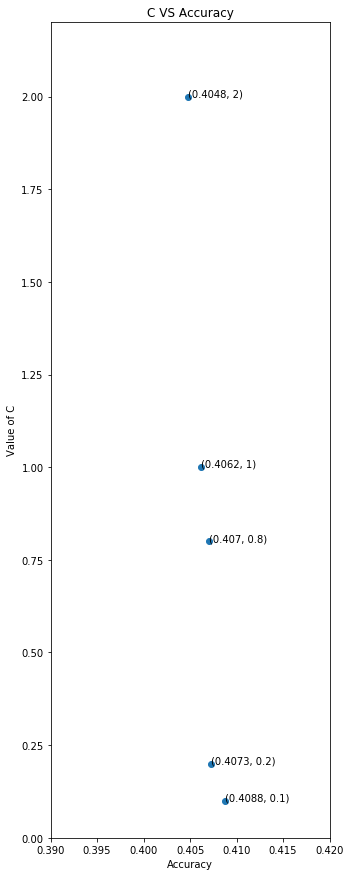

In [0]:
plt.figure(figsize=(5,15))
plt.scatter(accuracy, Cs)

for a,b in zip(accuracy, Cs): 
    plt.text(a, b, str((a,b)))

plt.xlim(0.39,0.42)
plt.ylim(0, 2.2)

plt.xlabel('Accuracy')
plt.ylabel('Value of C')
plt.title('C VS Accuracy')

plt.show()

##Using HOG Features
Histogram of Oriented Gradients, which are similar SIFT discriptors. While SIFT are calculated by the use of sparse scale oriented image points rotated to orientation of bins. It is done using calculating the derivative mask at discrete points, then a orientation binnig is done.


In [0]:
cfar_10 = svm_cfar10(C=0.8, kernel='linear', feature='hog')
cfar_10.train()
yact, ypred=cfar_10.predict()

print('\n\nAccuracy \t', '{0:.5f}'.format(accuracy_score(yact, ypred)))

_precision, _recall, _fscore, _support  = precision_recall_fscore_support(yact, ypred)

print('precision\t', ' '.join(["{0:.5f}".format(i) for i in _precision]))
print('recall   \t',    ' '.join(["{0:.5f}".format(i) for i in _recall]))
print('fscore   \t',    ' '.join(["{0:.5f}".format(i) for i in _fscore]))

print('\n\nConfusion Matrix')
print(confusion_matrix(yact, ypred))

print('\n\n\n\n')

(50000, 324)
LinearSVC(C=0.8, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)


Accuracy 	 0.53130
precision	 0.57472 0.59964 0.47577 0.42586 0.47419 0.45266 0.49246 0.54334 0.58511 0.61121
recall   	 0.62300 0.66200 0.37300 0.24700 0.44100 0.39200 0.68600 0.60800 0.60500 0.67600
fscore   	 0.59789 0.62928 0.41816 0.31266 0.45699 0.42015 0.57334 0.57386 0.59489 0.64198


Confusion Matrix
[[623  36  70  12  38   8  30  30 126  27]
 [ 39 662  16  12  20   2  51  26  80  92]
 [ 84  27 373  48 111 109 121  57  49  21]
 [ 56  53  75 247  92 153 167  77  23  57]
 [ 39  37  40  64 441  50 133 110  39  47]
 [ 22  29  76 101  65 392 137 121  20  37]
 [ 26  38  37  40  49  50 686  31  23  20]
 [ 34  18  55  33  76  73  37 608  15  51]
 [118 100  27   8  19   8  17  20 605  78]
 [ 43 104  15  15  19  21  14  39  54 676]]







##Using RBF Kernel instead of Linear Kernel

In [0]:
cfar_10 = svm_cfar10(C=0.8, kernel='rbf', feature='hog')
cfar_10.train()
yact, ypred=cfar_10.predict()

print('\n\nObatined ', cfar_10.get_support_vectors().__len__(), ' support vectors')
print('\n\nAccuracy \t', '{0:.5f}'.format(accuracy_score(yact, ypred)))

_precision, _recall, _fscore, _support  = precision_recall_fscore_support(yact, ypred)

print('precision\t', ' '.join(["{0:.5f}".format(i) for i in _precision]))
print('recall   \t',    ' '.join(["{0:.5f}".format(i) for i in _recall]))
print('fscore   \t',    ' '.join(["{0:.5f}".format(i) for i in _fscore]))

print('\n\nConfusion Matrix')
print(confusion_matrix(yact, ypred))

print('\n\n\n\n')

SVC(C=0.8, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


Obatined  40045  support vectors


Accuracy 	 0.64030
precision	 0.66819 0.76040 0.55469 0.47546 0.56120 0.51567 0.68475 0.71505 0.72131 0.72915
recall   	 0.72900 0.76800 0.49700 0.43600 0.61900 0.51000 0.73200 0.66500 0.70400 0.74300
fscore   	 0.69727 0.76418 0.52426 0.45488 0.58868 0.51282 0.70759 0.68912 0.71255 0.73601


Confusion Matrix
[[729  18  64  19  33   7  12   9  91  18]
 [ 23 768   9  15  19   6  23   5  55  77]
 [ 84  13 497  75 105  88  70  33  24  11]
 [ 33  29  80 436  88 171  79  45   7  32]
 [ 30  12  63  68 619  56  61  59  11  21]
 [ 24   8  62 157  76 510  62  70  13  18]
 [ 21  22  40  54  46  52 732   9  13  11]
 [ 21   6  42  62  75  76  13 665  10  30]
 [ 94  64  23  12  22   3   6  14 704  58]
 [ 32  70  16  

#Observation

Use of kernel and HOG features has reduced the size of feature vector from 32x32x3 to 324, where by linearSVC execution speeds have been lot faster than crude usage of image as features vector.

###USING KNN for the classification of CFAR-10

In [0]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        _dict = pickle.load(fo, encoding='bytes')
    return _dict

In [12]:
from sklearn.neighbors import KNeighborsClassifier
train_y = np.array([], dtype=np.int8)
train_x = np.array([], dtype=np.int8)
for file in ['data_batch_'+str(i) for i in range(1,6)]:
    _dict = unpickle(file)
    train_y = np.append(train_y ,_dict[b'labels'])
    if len(train_x) == 0:
        train_x = _dict[b'data']
    else:
        train_x = np.append(train_x, _dict[b'data'], axis=0)

knn_model = KNeighborsClassifier(n_neighbors=10)
print(knn_model)
knn_model.fit(train_x, train_y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='uniform')


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='uniform')

In [0]:
_dict = unpickle('test_batch')
test_y = np.append(np.array([]), _dict[b'labels'])
test_x = _dict[b'data']

knn_predict = knn_model.predict(test_x)


In [19]:
knn_predict, test_y

(array([4, 8, 8, ..., 5, 3, 4]), array([3., 8., 8., ..., 5., 1., 7.]))

In [20]:
print('KNN Accuracy')
print('Accuracy \t\t', accuracy_score(test_y, knn_predict))

KNN Accuracy
Accuracy 		 0.3386
